In [1]:
import pandas as pd
import gensim
import opencorpora
from pymystem3 import Mystem
from many_stop_words import get_stop_words
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
code = pd.read_csv('data/criminal_code.csv')
df = pd.read_csv('data/judicial_orders.csv').rename(columns={'title':'name'})
code['lemmas'] = code['lemmas'].map(eval)
df['lemmas'] = df['lemmas'].map(eval)

## Статьи кодекса и судебные решения

In [3]:
code['is_code'] = 1
df['is_code'] = 0

In [4]:
tmp = pd.concat([
    code[['name', 'lemmas','is_code']], 
    df[['name', 'lemmas', 'is_code']]
], ignore_index=True)

In [5]:
td = lambda row: gensim.models.doc2vec.TaggedDocument(
    words=row['lemmas'], 
    tags=[row.name]
)
documents = tmp.apply(td, axis=1).tolist()

In [6]:
%%time
model = gensim.models.doc2vec.Doc2Vec(alpha=0.025, min_alpha=0.025)
model.build_vocab(documents)
model.train(documents, total_examples=model.corpus_count, epochs=100)

CPU times: user 21min 19s, sys: 23.7 s, total: 21min 43s
Wall time: 8min 4s


In [7]:
docvec = dict(zip(model.docvecs.offset2doctag, model.docvecs.vectors_docs.tolist()))

In [8]:
tmp['vectors'] = model.docvecs.vectors_docs.tolist()

In [9]:
tmp['pca'] = PCA(n_components=2).fit_transform(tmp['vectors'].tolist()).tolist()

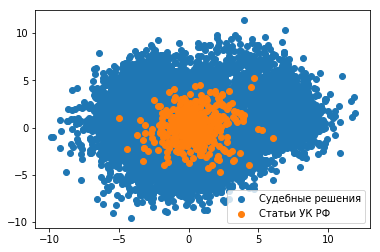

In [10]:
plt.scatter(
    x=tmp[tmp['is_code'] == 0]['pca'].map(lambda x: x[0]),
    y=tmp[tmp['is_code'] == 0]['pca'].map(lambda x: x[1]),
    label='Судебные решения'
)
plt.scatter(
    x=tmp[tmp['is_code'] == 1]['pca'].map(lambda x: x[0]),
    y=tmp[tmp['is_code'] == 1]['pca'].map(lambda x: x[1]),
    label='Статьи УК РФ'
)
plt.legend()
pass

In [11]:
import re
patt = re.compile("\\n|\\t|\\r")
clean_str = lambda s: re.sub(patt, ' ', s)

In [12]:
tmp['name'] = tmp['name'].map(clean_str)

In [13]:
tmp.drop(['lemmas'], axis=1).to_csv('results/doc2vec_all.csv', index=False)

### Вместе с opencorpora

In [14]:
reader = opencorpora.CorpusReader('data/opencorpora/annot.opcorpora.xml')

In [15]:
m = Mystem(entire_input=False)

In [16]:
def lemm_and_filter(text, stopwords=get_stop_words('ru')):
    lemmas = m.lemmatize(text)
    filter_cond = lambda word: word not in stopwords and len(word) > 3
    return list(filter(filter_cond, lemmas))

In [17]:
%%time
docs_iter = reader.iter_documents()
corpus = [(doc.title(), doc.raw(), lemm_and_filter(doc.raw())) for doc in docs_iter]

CPU times: user 2min 33s, sys: 3.12 s, total: 2min 37s
Wall time: 4min 1s


In [18]:
tmp = pd.DataFrame(corpus, columns=['name', 'body', 'lemmas'])

In [19]:
tmp = tmp.drop(tmp[tmp['lemmas'].map(len) == 0].index)

In [20]:
tmp['source'] = 'opencorpora'
code['source'] = 'criminal_code'
df['source'] = 'judgement'

In [21]:
tmp = pd.concat([
    tmp,
    code[['name', 'body', 'lemmas', 'source']],
    df.rename(columns={'case':'body'})[['name', 'body', 'lemmas', 'source']]
], ignore_index=True)

In [22]:
td = lambda row: gensim.models.doc2vec.TaggedDocument(
    words=row['lemmas'], 
    tags=[row.name]
)
documents = tmp.apply(td, axis=1).tolist()

In [23]:
%%time
model = gensim.models.doc2vec.Doc2Vec(alpha=0.025, min_alpha=0.025)
model.build_vocab(documents)
model.train(documents, total_examples=model.corpus_count, epochs=100)

CPU times: user 25min 5s, sys: 21.9 s, total: 25min 26s
Wall time: 9min 32s


In [24]:
tmp['name'] = tmp['name'].map(clean_str)

In [25]:
tmp['vectors'] = model.docvecs.vectors_docs.tolist()
tmp.drop(['lemmas', 'body'], axis=1).to_csv('results/doc2vec_with_opencorpora.csv', index=False)

In [26]:
tmp['pca'] = PCA(n_components=2).fit_transform(tmp['vectors'].tolist()).tolist()

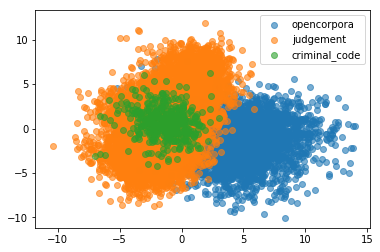

In [27]:
for source in ['opencorpora', 'judgement', 'criminal_code']:
    plt.scatter(
        x=tmp[tmp['source'] == source]['pca'].map(lambda x: x[0]),
        y=tmp[tmp['source'] == source]['pca'].map(lambda x: x[1]),
        label=source, 
        alpha=.6)
plt.legend()
pass

In [28]:
tmp_500 = pd.concat([
    tmp[tmp['source'] == 'opencorpora'].sample(500),
    tmp[tmp['source'] == 'judgement'].sample(500),
    tmp[tmp['source'] == 'criminal_code']
], ignore_index=True)[['name', 'source', 'vectors']]

In [29]:
tmp_500.to_csv('results/doc2vec_light.csv', index=False)

## Используя фразы

In [30]:
phraser = gensim.models.phrases.Phraser(gensim.models.phrases.Phrases(sentences=tmp['lemmas']))

In [31]:
td = lambda row: gensim.models.doc2vec.TaggedDocument(
    words=phraser[row['lemmas']], 
    tags=[row.name]
)
documents = tmp.apply(td, axis=1).tolist()

In [32]:
%%time
model = gensim.models.doc2vec.Doc2Vec(alpha=0.025, min_alpha=0.025)
model.build_vocab(documents)
model.train(documents, total_examples=model.corpus_count, epochs=100)

CPU times: user 22min 9s, sys: 33.9 s, total: 22min 43s
Wall time: 8min 54s


In [33]:
tmp['name'] = tmp['name'].map(clean_str)
tmp['vectors'] = model.docvecs.vectors_docs.tolist()
tmp.drop(['lemmas', 'body'], axis=1).to_csv('results/doc2vec_phrases.csv', index=False)

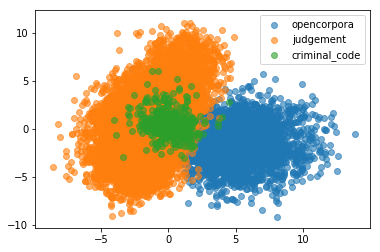

In [34]:
tmp['pca'] = PCA(n_components=2).fit_transform(tmp['vectors'].tolist()).tolist()
for source in ['opencorpora', 'judgement', 'criminal_code']:
    plt.scatter(
        x=tmp[tmp['source'] == source]['pca'].map(lambda x: x[0]),
        y=tmp[tmp['source'] == source]['pca'].map(lambda x: x[1]),
        label=source, 
        alpha=.6)
plt.legend()
pass

In [35]:
tmp_500 = pd.concat([
    tmp[tmp['source'] == 'opencorpora'].sample(500),
    tmp[tmp['source'] == 'judgement'].sample(500),
    tmp[tmp['source'] == 'criminal_code']
], ignore_index=True)

In [36]:
tmp_500.drop(['body', 'lemmas', 'pca'], axis=1)\
        .to_csv('results/doc2vec_phrases_light.csv', index=False)

## Измерение расстояний между множествами

### Расстояние Хаусдорфа

In [47]:
from scipy.spatial.distance import directed_hausdorff
import numpy as np

In [70]:
def sym_hausdorff(u, v):
    '''Find the general (symmetric) Hausdorff distance between two 2-D arrays of coordinates'''
    return max(directed_hausdorff(u, v)[0], directed_hausdorff(v, u)[0])

In [60]:
cc = np.array(tmp[tmp['source'] == 'criminal_code']['vectors'].tolist())
oc = np.array(tmp[tmp['source'] == 'opencorpora']['vectors'].tolist())
jo = np.array(tmp[tmp['source'] == 'judgement']['vectors'].tolist())

In [68]:
print("Между судебными решениями и текстами opencorpora: {}".format(sym_hausdorff(jo, oc)))

Между судебными решениями и текстами opencorpora: 34.03192053609774


In [66]:
print("Между статьями кодекса и текстами opencorpora: {}".format(sym_hausdorff(cc, oc)))

Между статьями кодекса и текстами opencorpora: 35.53737205024209


In [73]:
print("Между статьями кодекса и судебными решениями: {}".format(sym_hausdorff(cc, jo)))

Между статьями кодекса и судебными решениями: 30.266636463699488


## Создание порогового графа Уголовного кодекса

In [241]:
from scipy.spatial.distance import cosine
import seaborn as sns

In [242]:
code['vectors'] = tmp[tmp['source'] == 'criminal_code'].reset_index(drop=True)['vectors']

In [243]:
def measure_distances(vec_a):
    return code['vectors'].map(lambda vec_b: cosine(vec_a, vec_b)).tolist()

In [244]:
code['similarities'] = code['vectors'].map(measure_distances)

In [245]:
dist_matrix = np.array(code['similarities'].tolist())

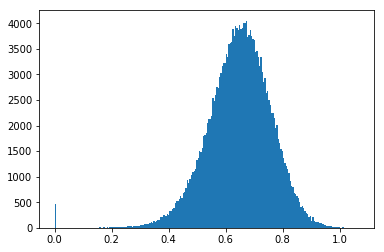

In [246]:
plt.hist(np.hstack(dist_matrix), bins='auto')
plt.show()

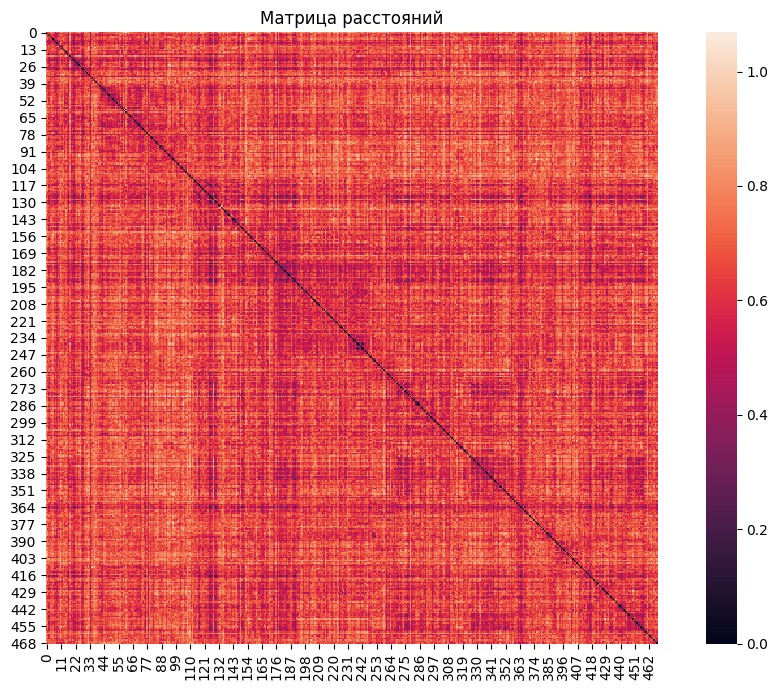

In [452]:
fig, ax = plt.subplots(figsize=(10,7), dpi=100)
sns.heatmap(dist_matrix, square=True, ax=ax)
plt.title('Матрица расстояний')
fig.tight_layout()
plt.show()

In [248]:
import networkx as nx
from matplotlib import cm

In [296]:
def filter_matrix(m, t):
    return (m <= t) * m

In [454]:
def plot_graph(threshold):
    graph = nx.from_pandas_adjacency(
        pd.DataFrame(filter_matrix(dist_matrix, threshold), 
                     index=code['number'], columns=code['number']))
    # Выбрасываем вершины без связей
    deg = graph.degree()
    sub = graph.subgraph([n for n in graph.nodes if deg[n] != 0])
    colors=list(map(lambda x: code[code['number'] == x]['section'].values[0], sub.nodes))
    return nx.draw_networkx(sub, pos=nx.drawing.kamada_kawai_layout(sub), 
                     font_color='black', font_size=9, node_color=colors,
                     cmap=cm.Set1, node_size=400)

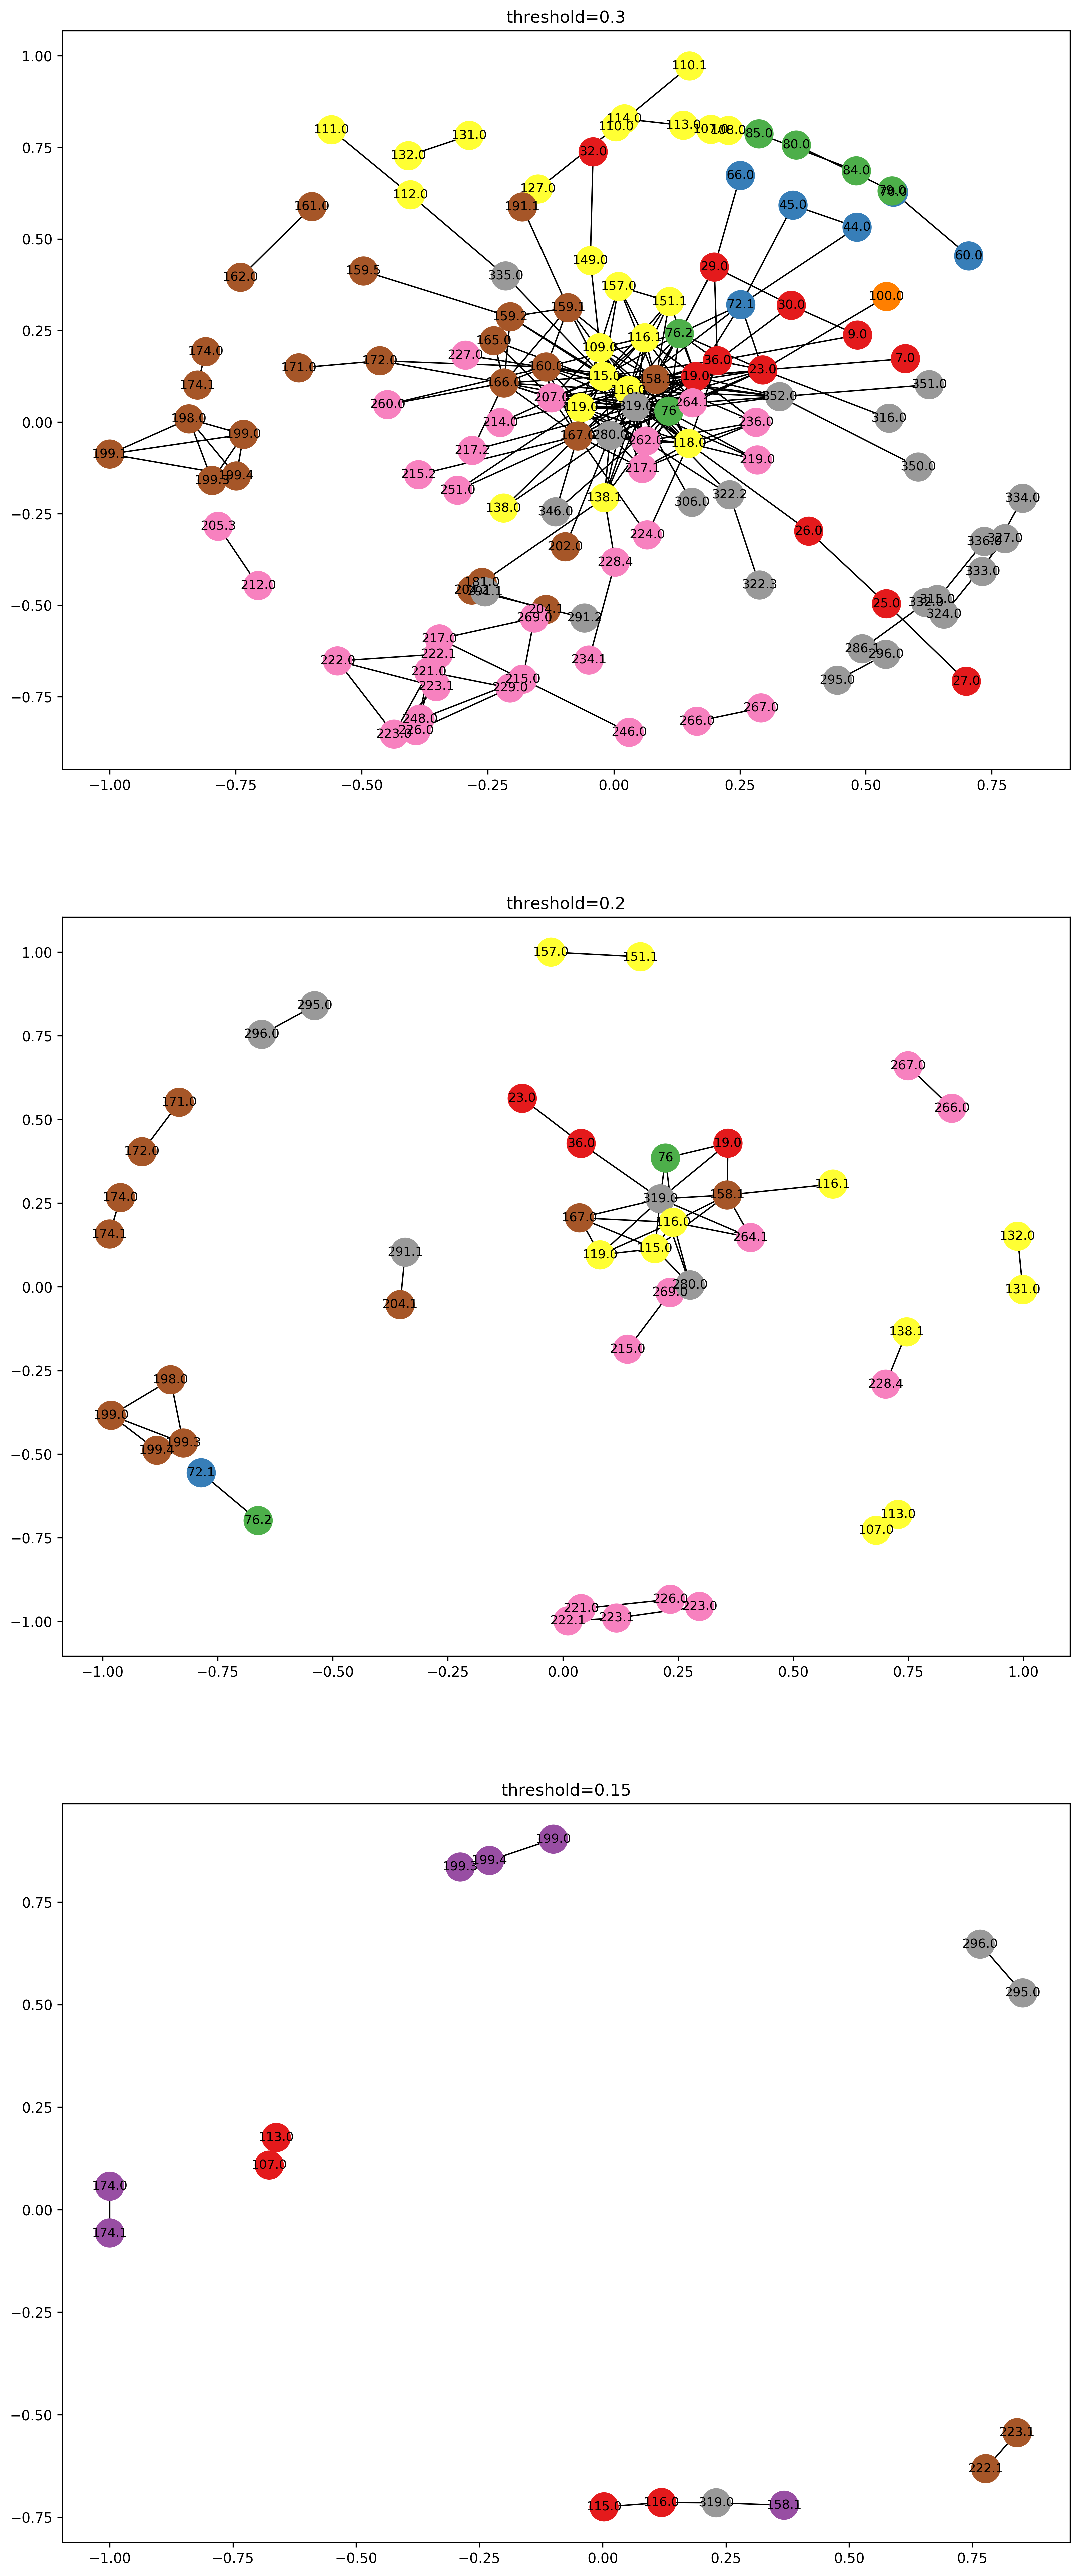

In [455]:
t = [0.3, 0.2, 0.15]
fig = plt.figure(figsize=(13, 45), dpi=300)
for i, ti in enumerate(t):
    fig.add_subplot(4,1,i+1)
#     plt.axis('off')
    plt.title('threshold={}'.format(ti))
    plot_graph(ti)